In [1]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torchvision import transforms

import multiprocessing

from video_autoencoder import VideoUNetAutoencoderNoSkips
from customDataset import CustomKineticsDataset_UNet

In [2]:
model = VideoUNetAutoencoderNoSkips(base_channels=32, latent_dim=8,p=0)

'\nJoao_4_fail - joint Torque\nJoao_2_fail - Collision\n10_Gui_Fail - Extra person\nGui_Fail_3 - Person Disappears\n1_p2_fail - drop cup\n3_p2_fail - robot human handover\n'

In [3]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = CustomKineticsDataset_UNet(root_dir='Labelled Dataset',
                                frames_per_clip=32,
                                transform=transform)

train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

{'Human Handover': 0, 'Idle': 1, 'Move No Cup': 2, 'Move with Cup': 3, 'Place': 4, 'Robot Handover': 5, 'Robot Picking Object': 6}


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train_autoencoder(model, train_loader, val_loader, num_epochs=20, lr=1e-3, device="cuda"):
    model = model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.3)

    best_val_loss = float("inf")
    all_train_losses = []
    all_val_losses = []

    for epoch in range(num_epochs):
        # -------- TRAIN --------
        model.train()
        train_loss = 0.0
        for clips, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):

            clips = clips.to(device)  # (B, C, T, H, W)

            optimizer.zero_grad()
            recon = model(clips)

            loss = criterion(recon, clips)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * clips.size(0)

        train_loss /= len(train_loader.dataset)
        all_train_losses.append(train_loss)

        # -------- VALIDATION --------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for clips, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):

                clips = clips.to(device)
                recon = model(clips)


                loss = criterion(recon, clips)
                val_loss += loss.item() * clips.size(0)

        val_loss /= len(val_loader.dataset)
        all_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_autoencoder.pth")
            print(f"✅ Saved new best model (val loss {val_loss:.6f})")

    return all_train_losses, all_val_losses



In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
all_train_losses, all_val_losses = train_autoencoder(model, train_loader, val_loader, num_epochs=40, lr=1e-6, device=device)

Epoch 1/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 1/40 | Train Loss: 0.171898 | Val Loss: 0.152977
✅ Saved new best model (val loss 0.152977)


Epoch 2/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 2/40 | Train Loss: 0.141037 | Val Loss: 0.129299
✅ Saved new best model (val loss 0.129299)


Epoch 3/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 3/40 | Train Loss: 0.119023 | Val Loss: 0.109022
✅ Saved new best model (val loss 0.109022)


Epoch 4/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 4/40 | Train Loss: 0.101559 | Val Loss: 0.094013
✅ Saved new best model (val loss 0.094013)


Epoch 5/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 5/40 | Train Loss: 0.088677 | Val Loss: 0.082834
✅ Saved new best model (val loss 0.082834)


Epoch 6/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 6/40 | Train Loss: 0.079235 | Val Loss: 0.074620
✅ Saved new best model (val loss 0.074620)


Epoch 7/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 7/40 | Train Loss: 0.072037 | Val Loss: 0.067857
✅ Saved new best model (val loss 0.067857)


Epoch 8/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 8/40 | Train Loss: 0.066604 | Val Loss: 0.063448
✅ Saved new best model (val loss 0.063448)


Epoch 9/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 9/40 | Train Loss: 0.062548 | Val Loss: 0.059854
✅ Saved new best model (val loss 0.059854)


Epoch 10/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.46s/it]


Epoch 10/40 | Train Loss: 0.059514 | Val Loss: 0.057205
✅ Saved new best model (val loss 0.057205)


Epoch 11/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 11/40 | Train Loss: 0.057038 | Val Loss: 0.055002
✅ Saved new best model (val loss 0.055002)


Epoch 12/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 12/40 | Train Loss: 0.055057 | Val Loss: 0.052947
✅ Saved new best model (val loss 0.052947)


Epoch 13/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 13/40 | Train Loss: 0.053332 | Val Loss: 0.051411
✅ Saved new best model (val loss 0.051411)


Epoch 14/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 14/40 | Train Loss: 0.051824 | Val Loss: 0.050134
✅ Saved new best model (val loss 0.050134)


Epoch 15/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 15/40 | Train Loss: 0.050501 | Val Loss: 0.048812
✅ Saved new best model (val loss 0.048812)


Epoch 16/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 16/40 | Train Loss: 0.049328 | Val Loss: 0.047760
✅ Saved new best model (val loss 0.047760)


Epoch 17/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 17/40 | Train Loss: 0.048297 | Val Loss: 0.046830
✅ Saved new best model (val loss 0.046830)


Epoch 18/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 18/40 | Train Loss: 0.047449 | Val Loss: 0.045966
✅ Saved new best model (val loss 0.045966)


Epoch 19/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 19/40 | Train Loss: 0.046641 | Val Loss: 0.045182
✅ Saved new best model (val loss 0.045182)


Epoch 20/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 20/40 | Train Loss: 0.045888 | Val Loss: 0.044507
✅ Saved new best model (val loss 0.044507)


Epoch 21/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 21/40 | Train Loss: 0.045208 | Val Loss: 0.044075
✅ Saved new best model (val loss 0.044075)


Epoch 22/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 22/40 | Train Loss: 0.044656 | Val Loss: 0.043272
✅ Saved new best model (val loss 0.043272)


Epoch 23/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 23/40 | Train Loss: 0.044050 | Val Loss: 0.042784
✅ Saved new best model (val loss 0.042784)


Epoch 24/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 24/40 | Train Loss: 0.043566 | Val Loss: 0.042252
✅ Saved new best model (val loss 0.042252)


Epoch 25/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 25/40 | Train Loss: 0.043020 | Val Loss: 0.041843
✅ Saved new best model (val loss 0.041843)


Epoch 26/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 26/40 | Train Loss: 0.042619 | Val Loss: 0.041364
✅ Saved new best model (val loss 0.041364)


Epoch 27/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 27/40 | Train Loss: 0.042266 | Val Loss: 0.040970
✅ Saved new best model (val loss 0.040970)


Epoch 28/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 28/40 | Train Loss: 0.041840 | Val Loss: 0.040807
✅ Saved new best model (val loss 0.040807)


Epoch 29/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 29/40 | Train Loss: 0.041410 | Val Loss: 0.040254
✅ Saved new best model (val loss 0.040254)


Epoch 30/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.46s/it]


Epoch 30/40 | Train Loss: 0.041116 | Val Loss: 0.039873
✅ Saved new best model (val loss 0.039873)


Epoch 31/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Epoch 31/40 | Train Loss: 0.040710 | Val Loss: 0.039616
✅ Saved new best model (val loss 0.039616)


Epoch 32/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 32/40 | Train Loss: 0.040421 | Val Loss: 0.039404
✅ Saved new best model (val loss 0.039404)


Epoch 33/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 33/40 | Train Loss: 0.040116 | Val Loss: 0.038946
✅ Saved new best model (val loss 0.038946)


Epoch 34/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Epoch 34/40 | Train Loss: 0.039874 | Val Loss: 0.038756
✅ Saved new best model (val loss 0.038756)


Epoch 35/40 [Val]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Epoch 35/40 | Train Loss: 0.039524 | Val Loss: 0.038406
✅ Saved new best model (val loss 0.038406)


Epoch 36/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 36/40 | Train Loss: 0.039270 | Val Loss: 0.038213
✅ Saved new best model (val loss 0.038213)


Epoch 37/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 37/40 | Train Loss: 0.039024 | Val Loss: 0.037889
✅ Saved new best model (val loss 0.037889)


Epoch 38/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Epoch 38/40 | Train Loss: 0.038765 | Val Loss: 0.037652
✅ Saved new best model (val loss 0.037652)


Epoch 39/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Epoch 39/40 | Train Loss: 0.038472 | Val Loss: 0.037407
✅ Saved new best model (val loss 0.037407)


Epoch 40/40 [Val]: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]

Epoch 40/40 | Train Loss: 0.038378 | Val Loss: 0.037373
✅ Saved new best model (val loss 0.037373)


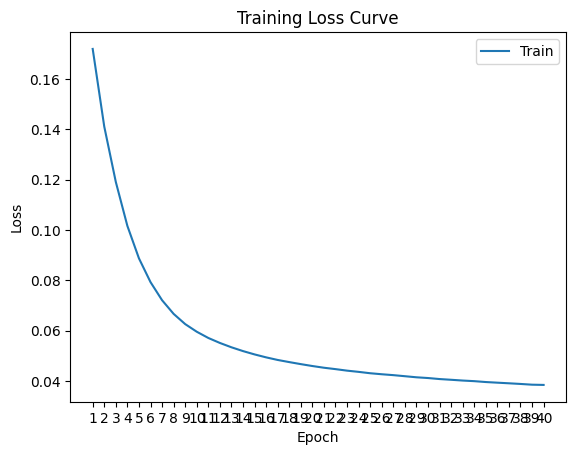

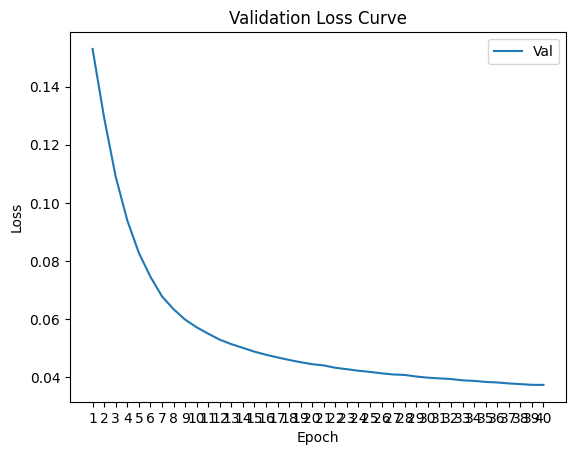

In [6]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.xticks(range(1, len(all_train_losses) + 1))  # Show all epoch numbers on x-axis
plt.show()

# Plot validation loss
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss Curve")
plt.xticks(range(1, len(all_val_losses) + 1))  # Show all epoch numbers on x-axis
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def denormalize(tensor):
    """
    Undo normalization: from [-1,1] back to [0,1] for visualization.
    Assumes you used mean=0.5, std=0.5 normalization.
    """
    return tensor * 0.5 + 0.5


def show_clip(original, recon, max_frames=8):
    """
    Display first `max_frames` frames from original and reconstruction.
    original, recon: tensors (C, T, H, W) in [-1,1]
    """

    if original.shape[0] == 1:
        original = np.transpose(original, (1, 2, 0))[:, :, 0]  # squeeze channel
        recon = np.transpose(recon, (1, 2, 0))[:, :, 0]
    else:
        original = np.transpose(original, (1, 2, 3, 0))
        recon = np.transpose(recon, (1, 2, 3, 0))

    num_frames = min(max_frames, original.shape[0])

    fig, axes = plt.subplots(2, num_frames, figsize=(3*num_frames, 6))
    for i in range(num_frames):
        axes[0, i].imshow(original[i], cmap='gray' if original.ndim==2 else None)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Orig {i}")

        axes[1, i].imshow(recon[i], cmap='gray' if recon.ndim==2 else None)
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Recon {i}")

    plt.show()

def plot_video_clips(clips, n_clips=4, n_frames=8):
    """
    Plot a few clips from a batch of video tensors.

    Args:
        clips (Tensor): Batch of clips, shape (B, C, T, H, W).
        n_clips (int): How many clips from the batch to plot.
        n_frames (int): How many frames per clip to show.
    """
    B, C, T, H, W = clips.shape
    n_clips = min(n_clips, B)
    n_frames = min(n_frames, T)

    fig, axes = plt.subplots(n_clips, n_frames, figsize=(n_frames*2, n_clips*2))

    # Handle case where only 1 clip is plotted
    if n_clips == 1:
        axes = [axes]

    for i in range(n_clips):
        # Evenly sample frames
        frame_indices = torch.linspace(0, T-1, steps=n_frames).long()
        for j, t in enumerate(frame_indices):
            frame = clips[i, :, t, :, :]  # (C, H, W)
            frame = torchvision.transforms.functional.to_pil_image(frame)

            axes[i][j].imshow(frame, cmap="gray" if frame.mode=="L" else None)
            axes[i][j].axis("off")

    plt.tight_layout()
    plt.show()


def plot_reconstructions(original, recon, n_clips=2, n_frames=8):
    """
    Plot original vs reconstructed video clips.

    Args:
        original (Tensor): Batch of original clips, shape (B, C, T, H, W).
        recon (Tensor): Batch of reconstructed clips, same shape.
        n_clips (int): Number of clips to show.
        n_frames (int): Number of frames per clip to show.
    """
    B, C, T, H, W = original.shape
    n_clips = min(n_clips, B)
    n_frames = min(n_frames, T)

    fig, axes = plt.subplots(n_clips*2, n_frames, figsize=(n_frames*2, n_clips*4))

    # Handle case where only 1 clip is plotted
    if n_clips == 1:
        axes = [axes]

    for i in range(n_clips):
        frame_indices = torch.linspace(0, T-1, steps=n_frames).long()

        for j, t in enumerate(frame_indices):
            # --- Original ---
            orig_frame = torchvision.transforms.functional.to_pil_image(original[i, :, t, :, :].cpu().clamp(0,1))
            axes[i*2][j].imshow(orig_frame, cmap="gray" if orig_frame.mode=="L" else None)
            axes[i*2][j].axis("off")
            if j == 0:
                axes[i*2][j].set_ylabel("Original", fontsize=12)

            # --- Reconstruction ---
            recon_frame = torchvision.transforms.functional.to_pil_image(recon[i, :, t, :, :].cpu().clamp(0,1))
            axes[i*2+1][j].imshow(recon_frame, cmap="gray" if recon_frame.mode=="L" else None)
            axes[i*2+1][j].axis("off")
            if j == 0:
                axes[i*2+1][j].set_ylabel("Reconstruction", fontsize=12)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2231608/278550254.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_autoencoder.pth"))


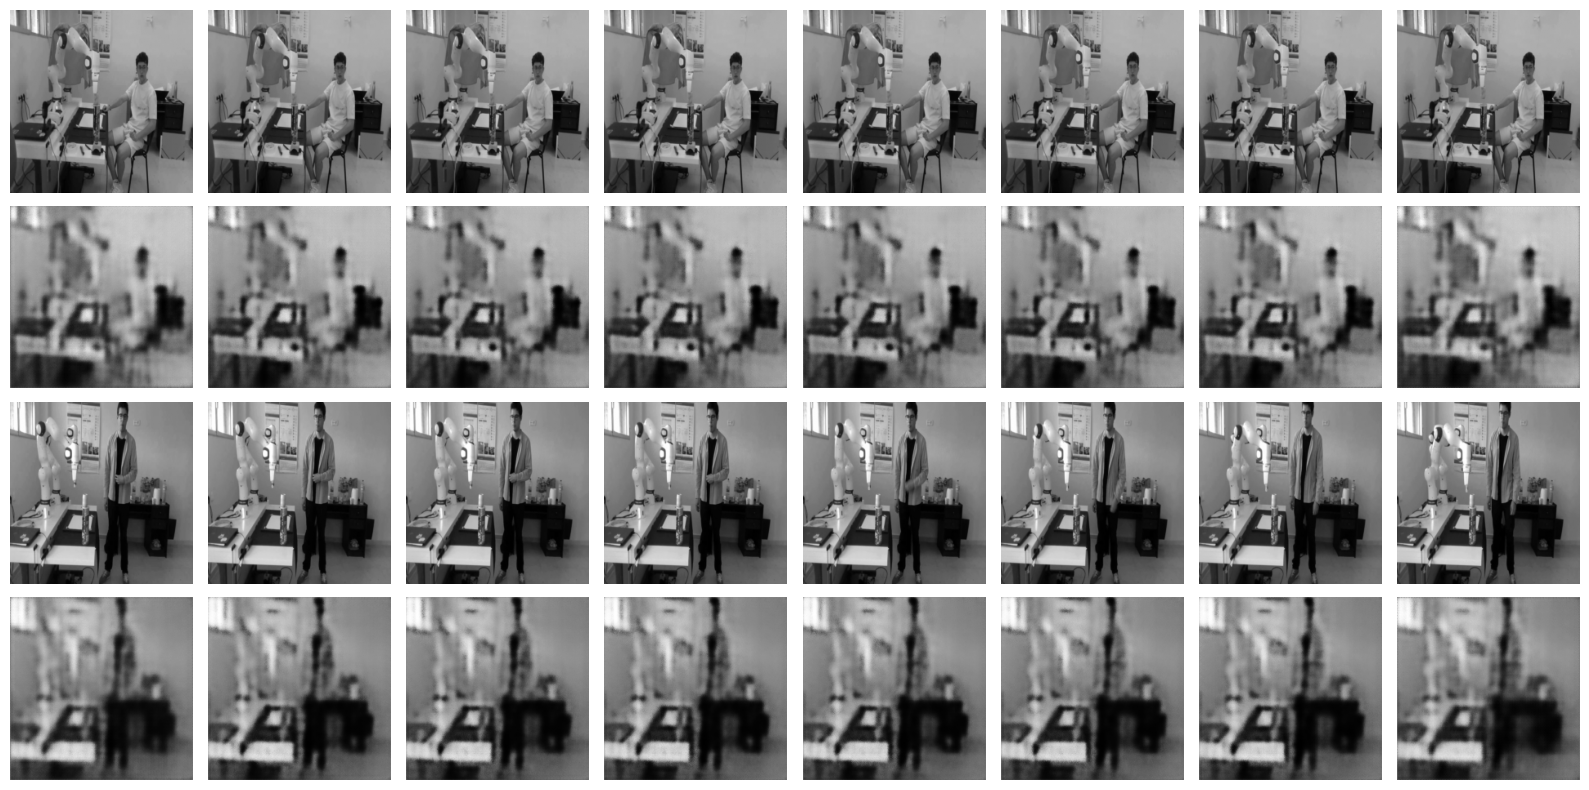

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.load_state_dict(torch.load("best_autoencoder.pth"))

model.eval()
model.to(device)

clips, _ = next(iter(test_loader))   # get a batch
clips = clips.to(device)

#plot_video_clips(clips, n_clips=2, n_frames=8)
with torch.no_grad():

    recon = model(clips)

plot_reconstructions(clips, recon, n_clips=2, n_frames=8)